<a href="https://colab.research.google.com/github/rrahul2203/Deep-learning-Computer-Vision/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Maintain the consistent performance
tf.random.set_seed(42)

# confirm GPU is available
print("Number of GPUs Available: " , len(tf.config.list_physical_devices('GPU')))

Number of GPUs Available:  1


In [2]:
# Loading the Fashion MNIST Dataset
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4431872/4422102 [==============================] - 0s 0us/step


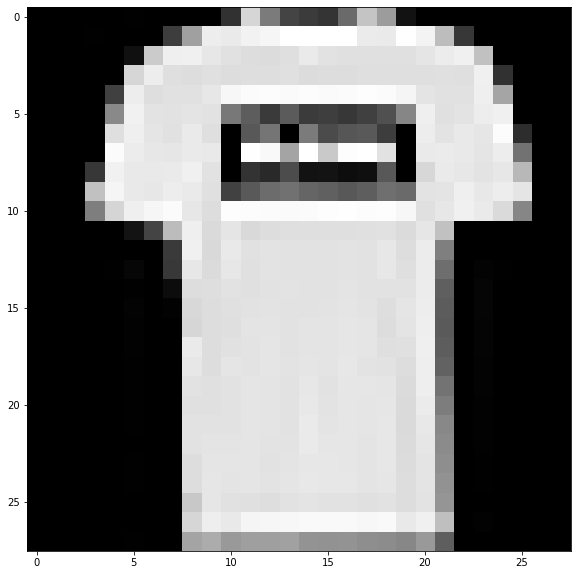

In [3]:
# Visualizing the dataset
plt.figure(figsize=(10,10))
plt.imshow(x_train[1], cmap='Greys_r')
plt.show()

In [4]:
# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
# normalize the images from [0, 255] to [0, 1]
dataset = np.expand_dims(dataset, -1).astype("float32")/255

In [5]:
BATCH_SIZE = 64

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1,28,28,1))
# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [6]:
NOISE_DIM = 150

## Define the generator model
generator  = keras.models.Sequential([
    layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    layers.Conv2DTranspose(256, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(128, 3, strides=2, activation="LeakyReLU", padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same"),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        1153      
 ranspose)                                                       
                                                        

In [7]:
## Define the discriminator model
discriminator = keras.models.Sequential([
    layers.InputLayer(input_shape=(28,28,1)),
    layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [8]:
# set different learning rates for the generator and dicriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversial game fails
# higher learning impact the stability of the adversial game severly
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metrics 
gAccMetrics = tf.keras.metrics.BinaryAccuracy()
dAccMetrics = tf.keras.metrics.BinaryAccuracy()

In [9]:
# observe the annonation allows for efficient native tensorflow compiling
@tf.function
def trainDStep(data):
  batchsize = tf.shape(data)[0]
  # create a noise vector as generator input sampled from Gaussian Random Normal
  # As an exercise try sampling from a uniform distribution and observe the difference 
  noise = tf.random.normal(shape=(batchsize, NOISE_DIM))
  # concatenate the real and fake labells
  y_true = tf.concat(
      [
          tf.ones(batchsize, 1),
          tf.zeros(batchsize, 1)
      ],
      axis = 0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    ## generate the faked samples
    fake = generator(noise)
    # concatenate the real and fake datasets 
    x = tf.concat([data, fake], axis = 0)
    # see the prediction from the discriminator 
    y_pred = discriminator(x)
    # calculate the discriminator loss 
    discriminatorLoss = lossFn(y_true, y_pred)
    
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # report accuracy
  dAccMetrics.update_state(y_true, y_pred)

  # return the loss for visulization 
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetrics.result()
  }

In [10]:
@tf.function
def trainGStep(data):
  batchsize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchsize, NOISE_DIM))
  # when training the generator we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchsize, 1)
  
  with tf.GradientTape() as tape:
    fake = generator(noise)
    y_pred = discriminator(fake)
    generatorLoss = lossFn(y_true, y_pred)
  
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))
  gAccMetrics.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetrics.result()
  }

In [11]:
def plotImages(model):
  images = model(np.random.normal(size=(81, NOISE_DIM)))
  plt.figure(figsize=(9,9))
  for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
    plt.axis('off')
  
  plt.show()

E:1, Generator Loss:0.6864331364631653, Discrminator Loss:0.5134382247924805, Generator Acc:0.8243447542190552, Discriminator Acc:97.58744049072266,
E:2, Generator Loss:0.6890277862548828, Discrminator Loss:0.5096877813339233, Generator Acc:0.6768665313720703, Discriminator Acc:97.89978790283203,


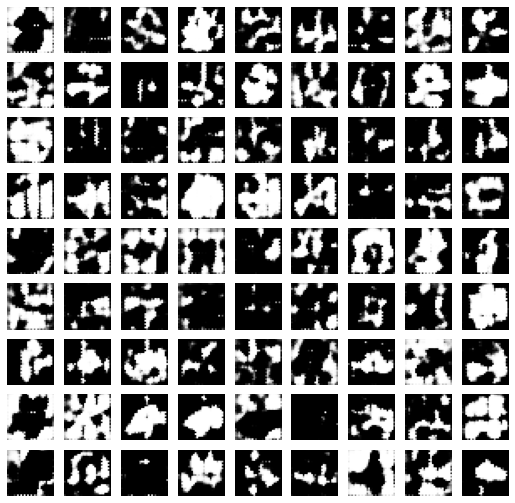

E:3, Generator Loss:0.6886625289916992, Discrminator Loss:0.5107144117355347, Generator Acc:0.5710892081260681, Discriminator Acc:98.16071319580078,
E:4, Generator Loss:0.6865959763526917, Discrminator Loss:0.5144315958023071, Generator Acc:0.5406134724617004, Discriminator Acc:98.1876449584961,


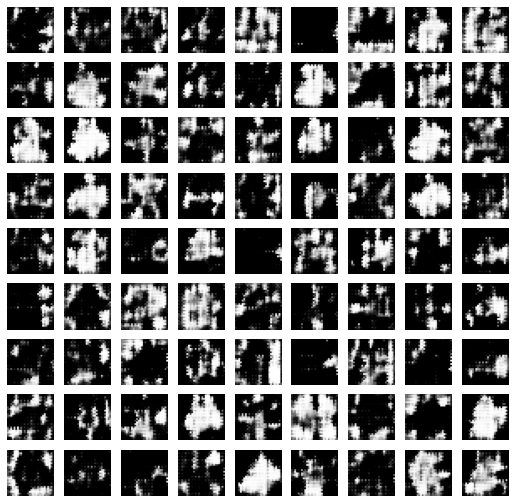

E:5, Generator Loss:0.6565806865692139, Discrminator Loss:0.583021342754364, Generator Acc:0.839100182056427, Discriminator Acc:97.31904602050781,
E:6, Generator Loss:0.6417357325553894, Discrminator Loss:0.61714106798172, Generator Acc:1.7451963424682617, Discriminator Acc:94.69577026367188,


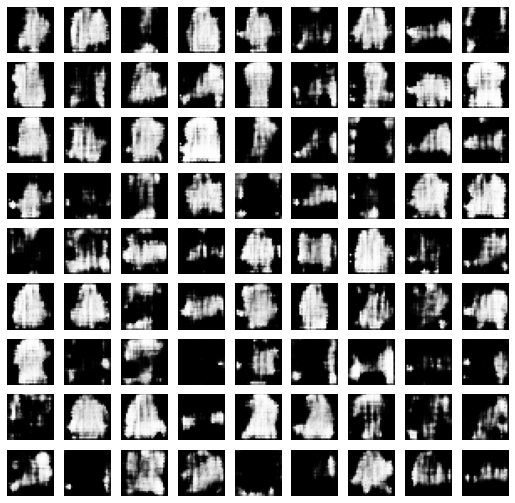

E:7, Generator Loss:0.6382508277893066, Discrminator Loss:0.6284127831459045, Generator Acc:2.5321993827819824, Discriminator Acc:92.3180923461914,
E:8, Generator Loss:0.6381599307060242, Discrminator Loss:0.6220665574073792, Generator Acc:3.041166305541992, Discriminator Acc:90.31073760986328,


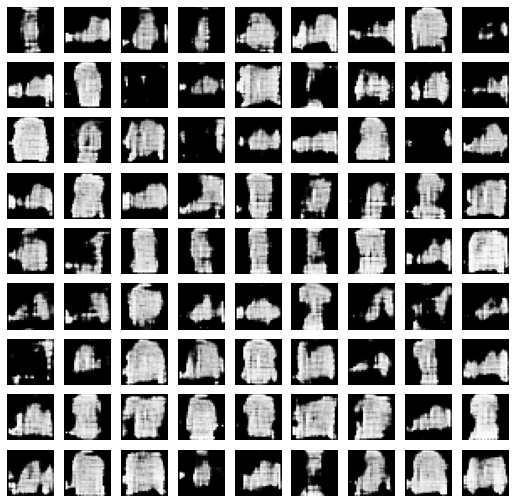

E:9, Generator Loss:0.6382988095283508, Discrminator Loss:0.6280099749565125, Generator Acc:3.374636650085449, Discriminator Acc:88.68106842041016,
E:10, Generator Loss:0.6390737891197205, Discrminator Loss:0.6190665364265442, Generator Acc:3.579638719558716, Discriminator Acc:87.35799407958984,


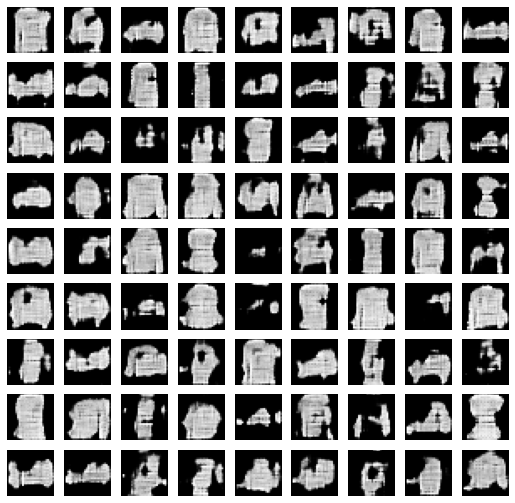

E:11, Generator Loss:0.639163076877594, Discrminator Loss:0.6167120337486267, Generator Acc:3.719313383102417, Discriminator Acc:86.36630249023438,
E:12, Generator Loss:0.6388189196586609, Discrminator Loss:0.613093376159668, Generator Acc:3.850222587585449, Discriminator Acc:85.59765625,


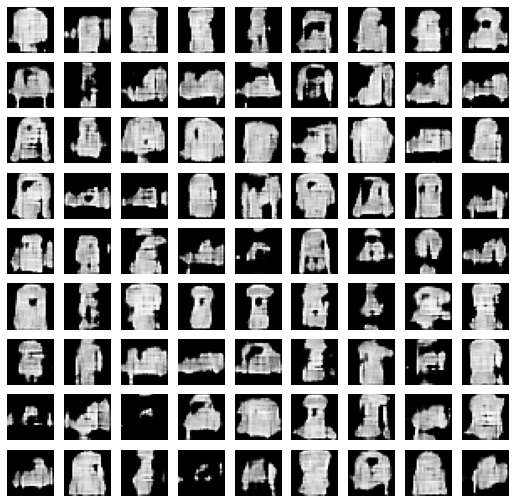

E:13, Generator Loss:0.6395230889320374, Discrminator Loss:0.6101834774017334, Generator Acc:3.969411849975586, Discriminator Acc:84.97278594970703,
E:14, Generator Loss:0.6396239995956421, Discrminator Loss:0.6090267896652222, Generator Acc:4.082237243652344, Discriminator Acc:84.48143768310547,


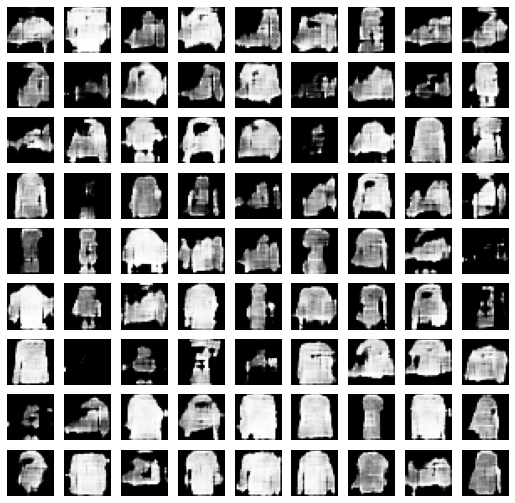

E:15, Generator Loss:0.641323447227478, Discrminator Loss:0.6110663414001465, Generator Acc:4.183029651641846, Discriminator Acc:84.00044250488281,
E:16, Generator Loss:0.6419393420219421, Discrminator Loss:0.6083483099937439, Generator Acc:4.268988132476807, Discriminator Acc:83.57756805419922,


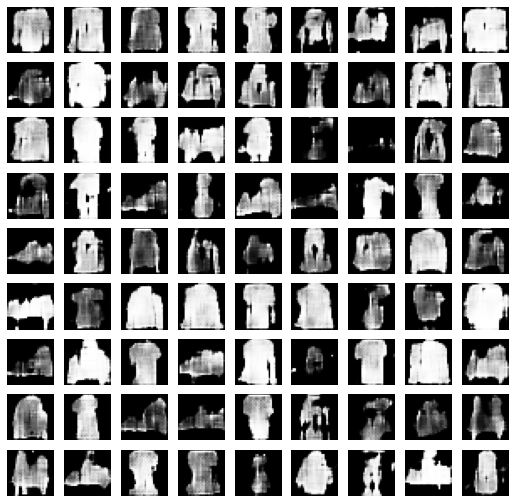

E:17, Generator Loss:0.6418492197990417, Discrminator Loss:0.6082194447517395, Generator Acc:4.338277339935303, Discriminator Acc:83.22164916992188,
E:18, Generator Loss:0.6406283378601074, Discrminator Loss:0.6086938381195068, Generator Acc:4.4156174659729, Discriminator Acc:82.88994598388672,


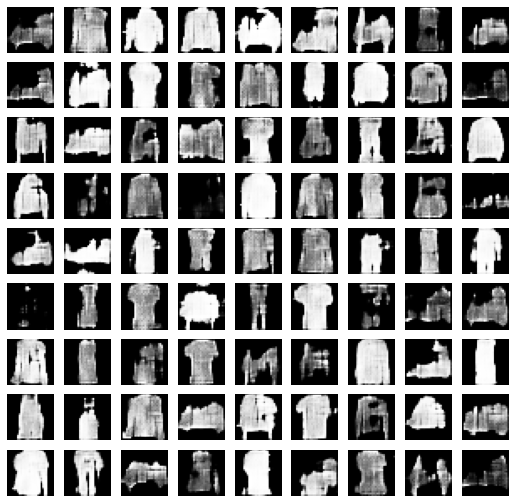

E:19, Generator Loss:0.6411532759666443, Discrminator Loss:0.6064239740371704, Generator Acc:4.493835926055908, Discriminator Acc:82.59481048583984,
E:20, Generator Loss:0.641657292842865, Discrminator Loss:0.6036416888237, Generator Acc:4.550036907196045, Discriminator Acc:82.35734558105469,


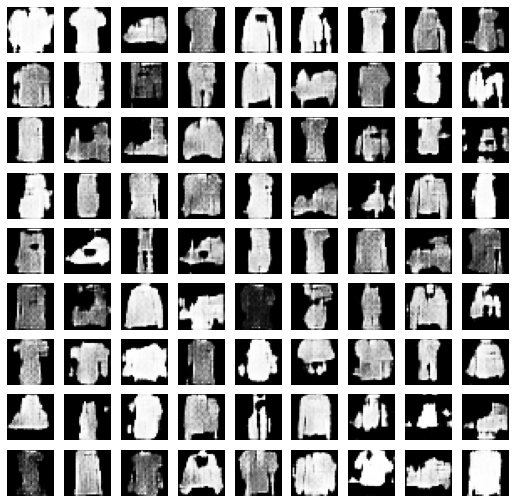

E:21, Generator Loss:0.6424773335456848, Discrminator Loss:0.6042634844779968, Generator Acc:4.593077659606934, Discriminator Acc:82.15130615234375,
E:22, Generator Loss:0.6428166031837463, Discrminator Loss:0.6038826107978821, Generator Acc:4.627226829528809, Discriminator Acc:81.95797729492188,


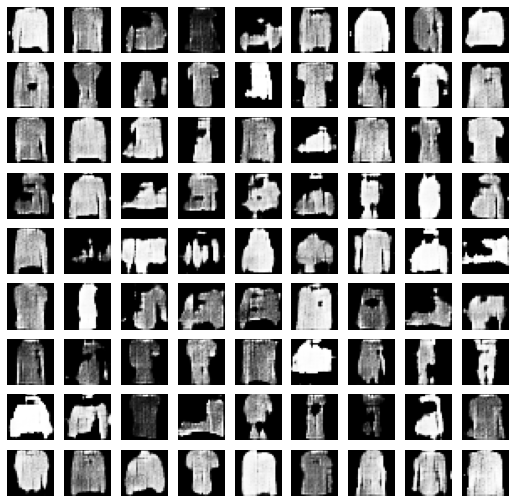

E:23, Generator Loss:0.6433140635490417, Discrminator Loss:0.6022859811782837, Generator Acc:4.6620707511901855, Discriminator Acc:81.78817749023438,
E:24, Generator Loss:0.6445037722587585, Discrminator Loss:0.6014446020126343, Generator Acc:4.689705848693848, Discriminator Acc:81.64350128173828,


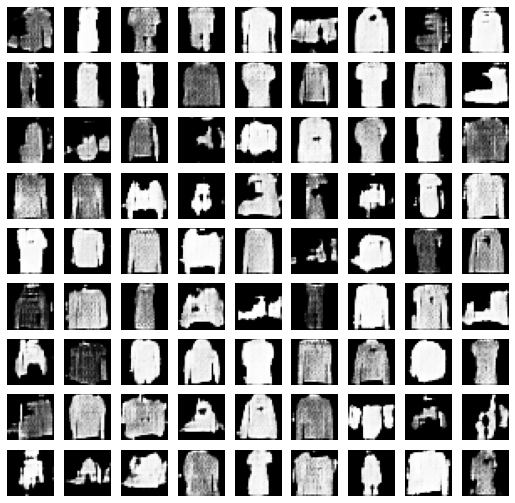

E:25, Generator Loss:0.6449316740036011, Discrminator Loss:0.6019896864891052, Generator Acc:4.704108715057373, Discriminator Acc:81.50694274902344,
E:26, Generator Loss:0.6452981233596802, Discrminator Loss:0.6013967990875244, Generator Acc:4.717343807220459, Discriminator Acc:81.37105560302734,


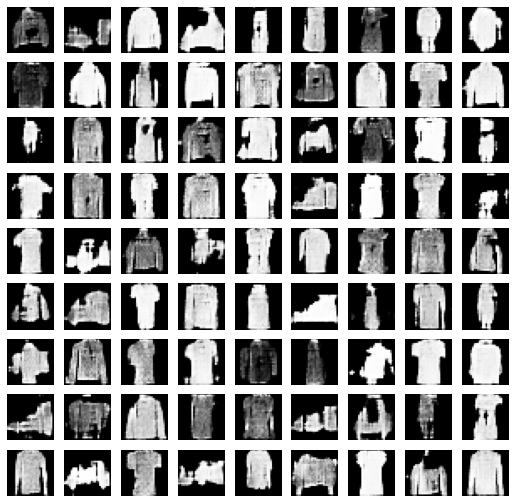

E:27, Generator Loss:0.645282506942749, Discrminator Loss:0.599866509437561, Generator Acc:4.728229999542236, Discriminator Acc:81.25112915039062,
E:28, Generator Loss:0.6451585292816162, Discrminator Loss:0.5972183346748352, Generator Acc:4.738383769989014, Discriminator Acc:81.16434478759766,


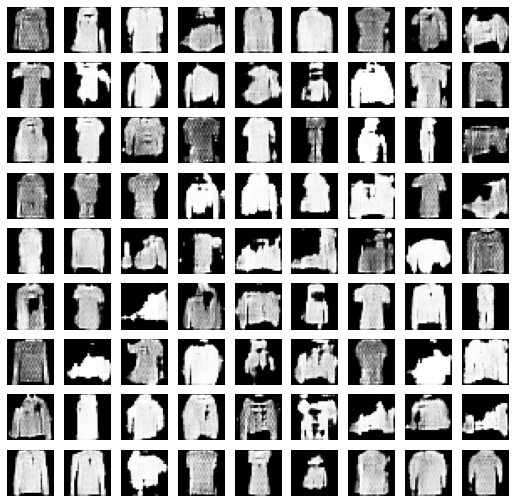

E:29, Generator Loss:0.6467466354370117, Discrminator Loss:0.5958450436592102, Generator Acc:4.74014139175415, Discriminator Acc:81.09986877441406,
E:30, Generator Loss:0.6465875506401062, Discrminator Loss:0.5961698889732361, Generator Acc:4.735862731933594, Discriminator Acc:81.03949737548828,


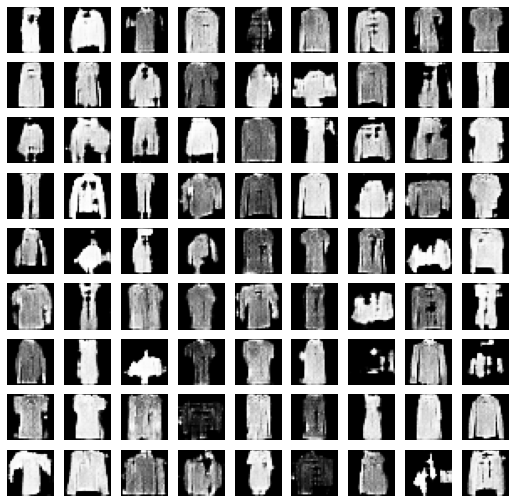

E:31, Generator Loss:0.6472413539886475, Discrminator Loss:0.5969207286834717, Generator Acc:4.7307448387146, Discriminator Acc:80.97909545898438,
E:32, Generator Loss:0.6475560069084167, Discrminator Loss:0.5984720587730408, Generator Acc:4.7276105880737305, Discriminator Acc:80.90534973144531,


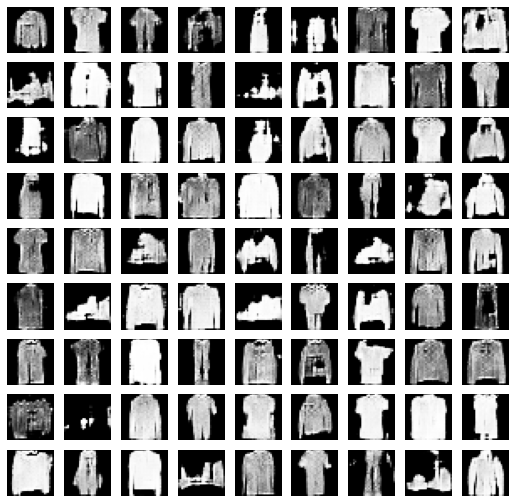

E:33, Generator Loss:0.6479495763778687, Discrminator Loss:0.5994926691055298, Generator Acc:4.725326061248779, Discriminator Acc:80.82524108886719,
E:34, Generator Loss:0.6477637887001038, Discrminator Loss:0.5993770956993103, Generator Acc:4.730216026306152, Discriminator Acc:80.7471923828125,


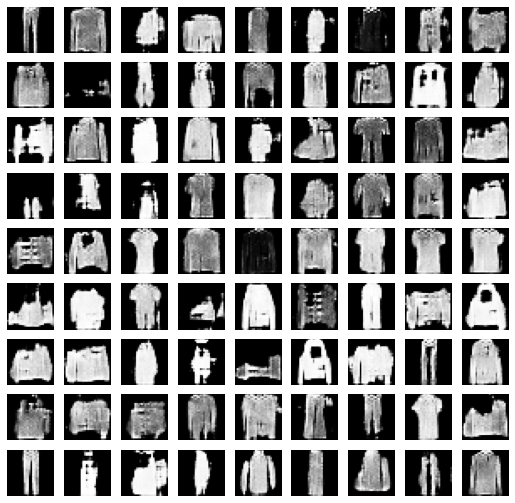

E:35, Generator Loss:0.6481841206550598, Discrminator Loss:0.5999000668525696, Generator Acc:4.728580474853516, Discriminator Acc:80.6722183227539,
E:36, Generator Loss:0.6492474675178528, Discrminator Loss:0.6013317704200745, Generator Acc:4.726137638092041, Discriminator Acc:80.5892333984375,


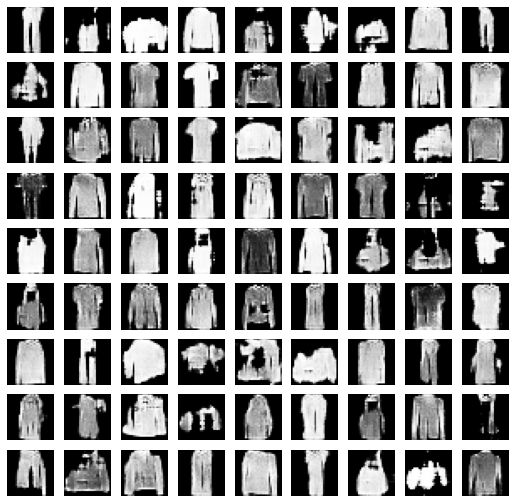

E:37, Generator Loss:0.6494146585464478, Discrminator Loss:0.6015519499778748, Generator Acc:4.718267440795898, Discriminator Acc:80.5012435913086,
E:38, Generator Loss:0.6488931775093079, Discrminator Loss:0.6013769507408142, Generator Acc:4.709756374359131, Discriminator Acc:80.42292785644531,


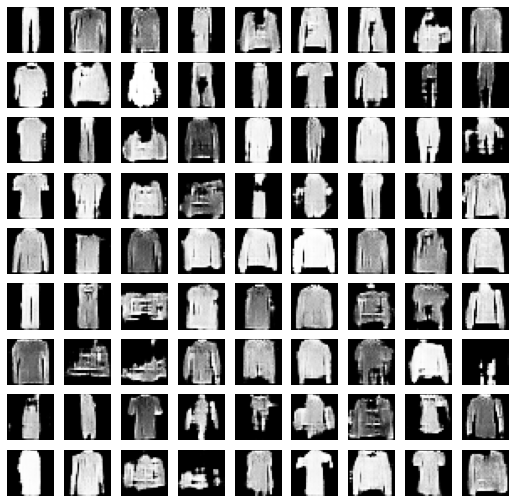

E:39, Generator Loss:0.6493401527404785, Discrminator Loss:0.6025077700614929, Generator Acc:4.701427936553955, Discriminator Acc:80.33820343017578,
E:40, Generator Loss:0.6498400568962097, Discrminator Loss:0.6033031940460205, Generator Acc:4.692267417907715, Discriminator Acc:80.24868774414062,


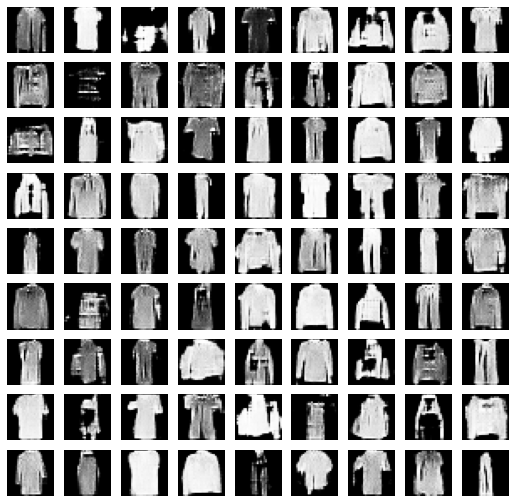

In [13]:
## Train the Discriminator and Generator
EPOCHS_NUM=40
for epoch in range(EPOCHS_NUM):
  ## accumulate the loss to calculate the loss at the end of each epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  count = 0
  for batch in dataset:
    ## train the discriminator --> In the orginal paper, there are mutliple 
    ## discriminator training steps per one generator training step. For 
    ## simplicity we are keeping one step of discriminator training and 
    ## generator training 
    dLoss = trainDStep(batch)
    dLossSum += dLoss["discriminator_loss"]
    dAccSum += dLoss["discriminator_accuracy"]

    ## train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss["generator_loss"]
    gAccSum += gLoss["generator_accuracy"]

    count += 1

  ## Log the performance
  print("E:{}, Generator Loss:{}, Discrminator Loss:{}, Generator Acc:{}, Discriminator Acc:{},".format(
      epoch+1, gLossSum/count, dLossSum/count, 100* gAccSum/count, 100* dAccSum/count))

  if (epoch+1)%2==0:
    plotImages(generator)

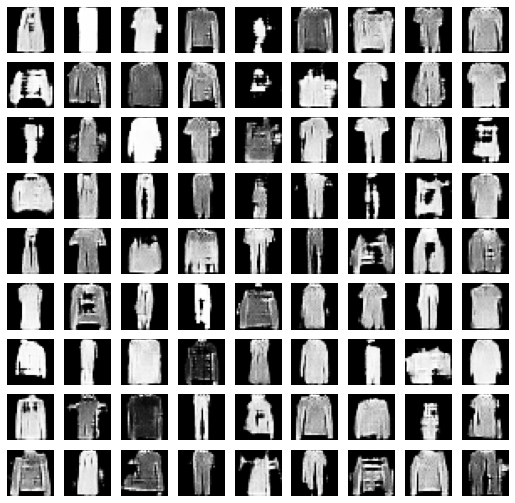

In [15]:
images = generator(np.random.normal(size=(81, NOISE_DIM)))
plt.figure(figsize=(9,9))
for i, image in enumerate(images):
  plt.subplot(9,9,i+1)
  plt.imshow(np.squeeze(image, -1), cmap='Greys_r')
  plt.axis('off')
  
plt.show()